## SMT based solution to VLSI circuit arrangement problem otherwise known as 2 dimensional strip packing problem

##Importing the libraries needed.

In [2]:
!pip install z3-solver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53.8 MB 130 bytes/s 


In [3]:
!pip install timeout-decorator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5028 sha256=c5b1f8ac776fa111d416e55ee1c2b20550ee10d4bf018c58fd209000334e79fb
  Stored in directory: /root/.cache/pip/wheels/7d/64/ac/de1dd54f9a6e48b846e9cb5e4176d6f063380e7f83d69807ad
Successfully built timeout-decorator


creating function to be able to plot each instance in a grid.

In [4]:
#ploying the results

import matplotlib.pyplot as plt
import random
import numpy as np
def plot_vlsi(p_x_sol,p_y_sol,x,y, length_sol, image_name):
  fig, ax = plt.subplots(figsize=[5,5])
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

  def plot_rect(ax,x,y,w,h):
      r = random.random()
      b = random.random()
      g = random.random()
      color = (random.random(), random.random(), random.random())
      rect = plt.Rectangle((x,y), w, h,color=color)
      ax.add_patch(rect)    
  for i in range(len(p_x_sol)):
      plot_rect(ax,int(p_x_sol[i]),int(p_y_sol[i]),int(x[i]),int(y[i]))
  plt.axis('square')
  plt.xticks(np.arange(0, w+1, 1))
  plt.yticks(np.arange(0, int(length_sol)+1, 1))
  plt.grid(color = 'black', linestyle = '-', linewidth = 1)
  plt.axis('on') 
  plt.savefig(image_name, bbox_inches='tight',pad_inches = 0)
  return plt.show()



##Model with rotations allowed

In [5]:
def read_data(file):
  with open(file, 'r') as file:
    data=file.read().splitlines()
    
    w=data[0]
    n=data[1]
    x=[]
    y=[]
    for item in range(int(n)):
      split = data[item + 2].split(' ')
      x.append(int(split[0]))
      y.append(int(split[1]))
  return(int(w), int(n), x, y)
imagenames=['r1','r2','r3','r4','r5','r6','r7','r8','r9','r10','r11','r12','r13','r14','r15','r16','r17','r18','r19','r20','r21','r22','r23','r24','r25','r26','r27','r28','r29','r30','r31','r32','r33','r34','r35','r36','r37','r38','r39','r40']
file_names=["ins-1.txt","ins-2.txt","ins-3.txt","ins-4.txt","ins-5.txt","ins-6.txt","ins-7.txt","ins-8.txt","ins-9.txt","ins-10.txt","ins-11.txt", "ins-12.txt","ins-13.txt","ins-14.txt","ins-15.txt","ins-16.txt","ins-17.txt","ins-18.txt","ins-19.txt","ins-20.txt","ins-21.txt","ins-22.txt","ins-23.txt","ins-24.txt","ins-25.txt","ins-26.txt","ins-27.txt","ins-28.txt","ins-29.txt","ins-30.txt","ins-31.txt","ins-32.txt","ins-33.txt","ins-34.txt","ins-35.txt","ins-36.txt","ins-37.txt","ins-38.txt","ins-39.txt","ins-40.txt"]

#imagenames=['r1','r2','r3','r4','r5','r6','r7','r8','r9','r10','r11']

#file_names=["ins-1.txt","ins-2.txt","ins-3.txt","ins-4.txt","ins-5.txt","ins-6.txt","ins-7.txt","ins-8.txt","ins-9.txt","ins-10.txt","ins-11.txt"]




In [6]:
from z3 import *
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

def two_d_smt_r(x_ext, y_ext, plate_width, n,name):
    opt = Optimize()

    areas = [x_ext[i] * y_ext[i] for i in range(n)]
    min_h = sum(areas)/plate_width
    max_h = 2*(sum(areas)/plate_width)

    p_x = [Int('p_x_%s' % str(i + 1)) for i in range(n)]
    p_y = [Int('p_y_%s' % str(i + 1)) for i in range(n)]
    rotation = [Bool("rot_%s" % str(i+1)) for i in range(n)]

    # real dimensions of circuits considering rotation
    x_r = [If(And(x_ext[i] != y_ext[i], rotation[i]), y_ext[i], x_ext[i]) for i in range(n)]
    y_r = [If(And(x_ext[i] != y_ext[i], rotation[i]), x_ext[i], y_ext[i]) for i in range(n)]
    plate_y = Int("y")
    
    # domain bound
    for i in range(n):
        opt.add(And(p_x[i] >= 0, p_x[i] <= (plate_width - x_r[i])))
        opt.add(And(p_y[i] >= 0, p_y[i] <= (plate_y - y_r[i])))
    opt.add(And(plate_y >= min_h, plate_y <= max_h))
    #plate_y = opt.z3_max([p_y[i] + y[i] for i in range(n)])
    #cumulative constraint
    for up in range(plate_width):
        opt.add(sum([If(And(p_x[i] <= up, up < p_x[i] + x_r[i]), y_r[i], 0) for i in range(n)]) <= plate_y)

    # cumulative constraint
    for uh in range(round(max_h)):
        opt.add(sum([If(And(p_y[i] <= uh, uh < p_y[i] + y_r[i]), x_r[i], 0) for i in range(n)]) <= plate_width)

    # domain reduction
    areas_index = np.argsort([x_ext[i]*y_ext[i] for i in range(n)])
    idx = np.argmax([x_ext[i]*y_ext[i] for i in range(n)])
  
    large_one = areas_index[-1], areas_index[-2]
    opt.add(And(p_x[idx] <= ((plate_width - x_ext[idx])/2), p_y[idx] <= ((plate_y - y_ext[idx])/2)))
    opt.add(Or(p_x[large_one[1]] > p_x[large_one[0]], And(p_x[large_one[1]] == p_x[large_one[0]], p_y[large_one[1]] >= p_y[large_one[0]])))
    #opt.add(And(p_x[idx] ==0, p_y[idx]==0))
    zlr = [[Bool(f"lr_{i}_{j}") for j in range(n)] for i in range(n)]
    zud = [[Bool(f"ud_{i}_{j}") for j in range(n)] for i in range(n)]
    
    for (i, j) in combinations(range(n), 2):
        if x_ext[i] + x_ext[j] > plate_width:
            opt.add(Or(Not(zud[i][j]), p_y[i] + y_r[i] <= p_y[j]))
            opt.add(Or(Not(zud[j][i]), p_y[j] + y_r[j] <= p_y[i]))
            opt.add(Or(zud[i][j], zud[j][i]))
        else:
            opt.add(Or(Not(zlr[i][j]), p_x[i] + x_r[i] <= p_x[j]))
            opt.add(Or(Not(zlr[j][i]), p_x[j] + x_r[j] <= p_x[i]))
            opt.add(Or(Not(zud[i][j]), p_y[i] + y_r[i] <= p_y[j]))
            opt.add(Or(Not(zud[j][i]), p_y[j] + y_r[j] <= p_y[i]))
            opt.add(Or(zlr[i][j], zlr[j][i], zud[i][j], zud[j][i]))

        



    # there are more rectangles in the second half of the x axis then in the first half
    opt.add(sum([If(p_x[i]+ x_r[i] > plate_width // 2, 1, 0) for i in range(n)]) >= sum([If(p_x[i] + x_r[i] <= plate_width // 2, 1, 0) for i in range(n)]))
    
    #for same size rectengles i and j we define that i should be left of j. and/or below j.
    for (i, j) in combinations(range(n), 2):
            if (x_ext[i]==x_ext[j] and y_ext[i]==y_ext[j]):
              opt.add(Or(Not(zlr[i][j]), p_x[i] + x_r[i] <= p_x[j]))
              opt.add(Or(Not(zud[i][j]), p_y[i] + y_r[i] <= p_y[j]))
              opt.add(Or(zlr[i][j],zud[i][j]))


    #rotation Constraints

    #handling rotation symmetry 
   
   # for (i, j) in combinations(range(n), 2):
        #if (rotation[i]==rotation[j]):
          #opt.add(Or(p_x[i] > p_x[j], And(p_x[i] == p_x[j], p_y[i] >= p_y[j])))
        #if (x_ext[i]==x_ext[j] or y_ext[i]==y_ext[j]):

    """     # opt.add(Or(p_x[i] > p_x[j], And(p_x[i] == p_x[j], p_y[i] >= p_y[j])))
    for i in range(n):
      if (y_ext[i]==plate_width):
        opt.add(rotation[i]==True)
        opt.add(p_y[i]<plate_y/2)
      if (y_ext[i]>plate_width):
        opt.add(rotation[i]==False)
    for (i,j) in combinations(range(n),2):
      if (y_ext[i]==y_ext[j]==plate_width):
        opt.add(zud[i][j]==True)"""


          

    opt.minimize(plate_y)

    timeout = 300000
    opt.set("timeout", timeout)
    p_x_sol = []
    p_y_sol = []
    y_r_sol = []
    x_r_sol = []
    rot_sol = []
    out = opt.check()
    model = opt.model()
    for i in range(n):
        p_x_sol.append(model.evaluate(p_x[i]).as_string())
        p_y_sol.append(model.evaluate(p_y[i]).as_string())
        y_r_sol.append(model.evaluate(y_r[i]).as_string())
        x_r_sol.append(model.evaluate(x_r[i]).as_string())
        rot_value = model[rotation[i]]
        if rot_value is None:
          rot_sol.append(False)
        else:
          rot_sol.append(rot_value)
    e = model.evaluate(plate_y).as_string()
    if out == sat:
        solved=1
        print("this instance is satisfiable")
        #plot_vlsi(str(p_x_sol),p_y_sol,x,y, e, name)
        for i in range(n):
          print("circuit "+str(i+1)+ " of the dimensions " + str(x[i])+"X"+str(y[i])+" is at ("+str(p_x_sol[i])+","+str(p_y_sol[i])+").\n")
        print(rot_sol)
        return e, p_x_sol, p_y_sol,x_r_sol,y_r_sol, opt.statistics().get_key_value('time'), rot_sol,solved
    print('Failed to solve')
    return e, p_x_sol, p_y_sol,x_r_sol,y_r_sol, 0, rot_sol, 0

In [7]:
import time
T_sym_R=[]
heights2=[]
solutions_r=[]
for file in file_names:
  print("solving Instance : "+file)
  w, n, x, y = read_data(file)
  name=imagenames[file_names.index(file)]
  length_sol, p_x_sol, p_y_sol,x,y, t, rot, solution=two_d_smt_r(x,y,w,n,name)
  solutions_r.append(solution)
  #plot_vlsi(p_x_sol,p_y_sol,x,y, length_sol, name)
  if solution==1:
    T_sym_R.append(t)
    heights2.append(length_sol)
  else:
    T_sym_R.append(0)
    heights2.append(length_sol)
  print(length_sol)
  print("Solves in time :"+str(t)+"seconds")


solving Instance : ins-1.txt
this instance is satisfiable
circuit 1 of the dimensions 3X3 is at (0,5).

circuit 2 of the dimensions 3X5 is at (5,0).

circuit 3 of the dimensions 5X3 is at (3,5).

circuit 4 of the dimensions 5X5 is at (0,0).

[False, False, False, False]
8
Solves in time :0.023seconds
solving Instance : ins-2.txt
this instance is satisfiable
circuit 1 of the dimensions 3X3 is at (3,6).

circuit 2 of the dimensions 3X4 is at (6,0).

circuit 3 of the dimensions 3X5 is at (6,4).

circuit 4 of the dimensions 3X6 is at (3,0).

circuit 5 of the dimensions 3X9 is at (0,0).

[False, False, False, False, False]
9
Solves in time :0.028seconds
solving Instance : ins-3.txt
this instance is satisfiable
circuit 1 of the dimensions 3X3 is at (3,4).

circuit 2 of the dimensions 3X4 is at (6,0).

circuit 3 of the dimensions 3X6 is at (0,4).

circuit 4 of the dimensions 3X7 is at (3,7).

circuit 5 of the dimensions 4X4 is at (6,3).

circuit 6 of the dimensions 4X6 is at (0,0).

[False, T

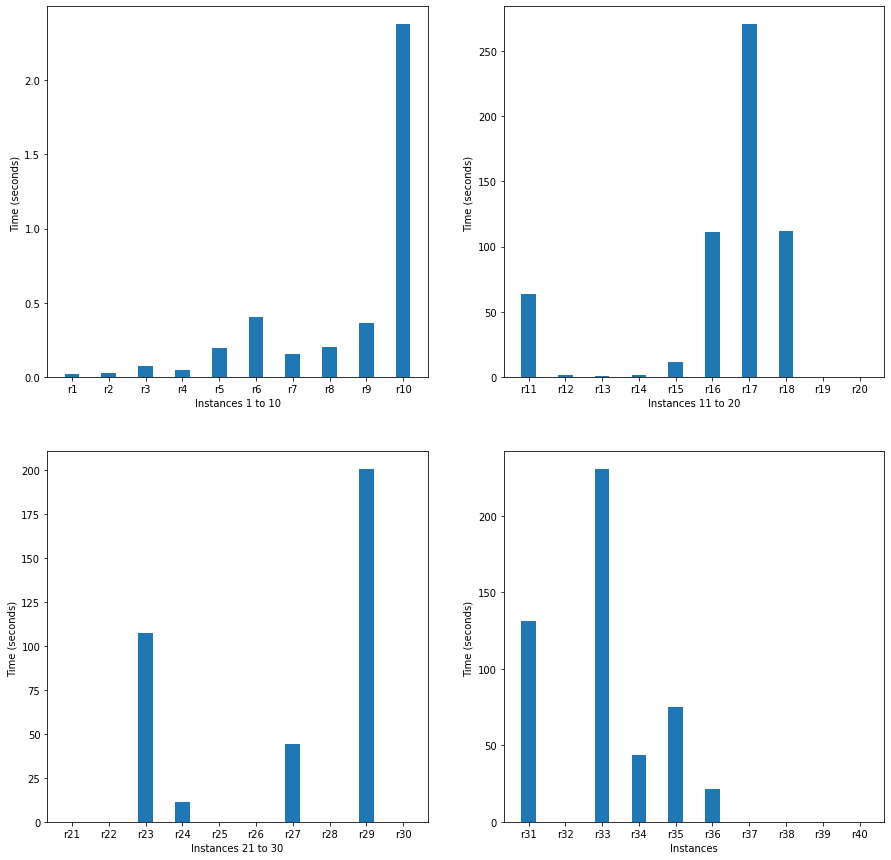

In [8]:
fig = plt.figure(figsize = (15, 15))
plt.subplot(221)
# creating the bar plot
plt.bar(imagenames[0:10], T_sym_R[0:10],
        width = 0.4)
    
plt.xlabel("Instances 1 to 10")
plt.ylabel("Time (seconds) ")
plt.subplot(222)
# creating the bar plot
plt.bar(imagenames[10:20], T_sym_R[10:20],
        width = 0.4)

plt.xlabel("Instances 11 to 20")
plt.ylabel("Time (seconds) ")
plt.subplot(223)
# creating the bar plot
plt.bar(imagenames[20:30], T_sym_R[20:30],
        width = 0.4)
 
plt.xlabel("Instances 21 to 30")
plt.ylabel("Time (seconds) ")
plt.subplot(224)
# creating the bar plot
plt.bar(imagenames[30:40], T_sym_R[30:40],
        width = 0.4)
 
plt.xlabel("Instances")
plt.ylabel("Time (seconds) ")

plt.savefig("results withrotation", bbox_inches='tight',pad_inches = 0)
plt.show()

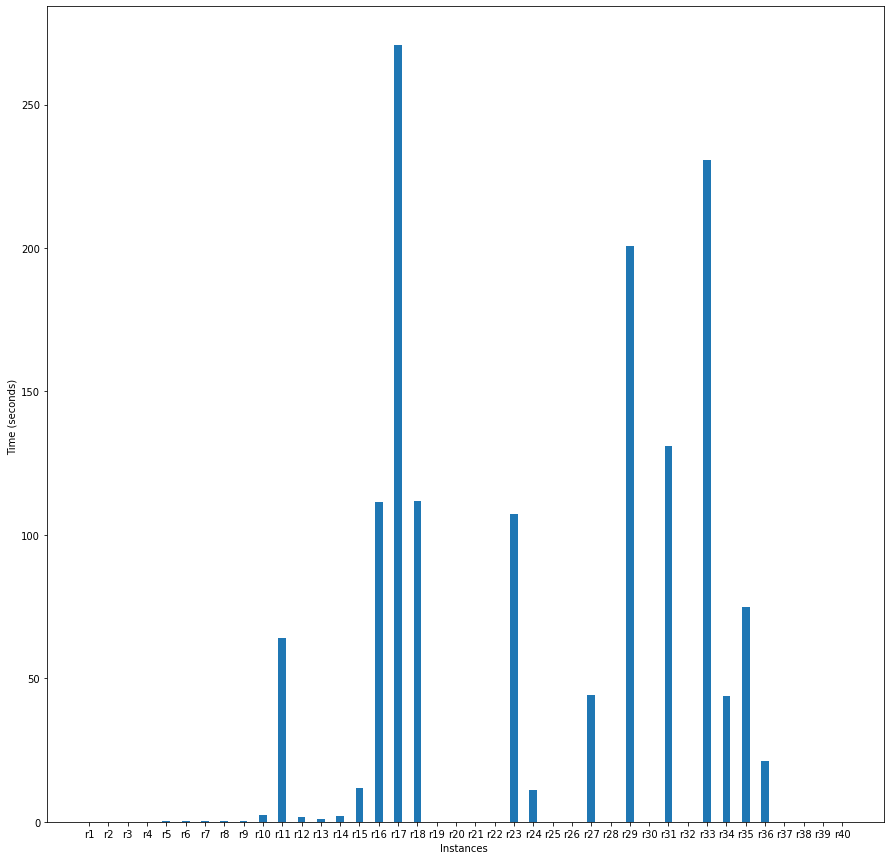

In [9]:
fig = plt.figure(figsize = (15, 15))
# creating the bar plot
plt.bar(imagenames, T_sym_R, width = 0.4)
 
plt.xlabel("Instances ")
plt.ylabel("Time (seconds) ")
 
plt.savefig("results with rotation", bbox_inches='tight',pad_inches = 0)
plt.show()

In [10]:
a=0
for i in range(len(T_sym_R)):
  if T_sym_R[i]!=0:
    a=a+1
print("The number of instances solved are: "+ str(a))

The number of instances solved are: 27


In [11]:
print(heights2)
print(T_sym_R)

['8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '52', '50', '56', '48', '30', '31', '64', '66', '34', '70', '36', '74', '38', '77', '40', '40', '40', '40', '120', '120', '120', '180']
[0.023, 0.028, 0.075, 0.047, 0.197, 0.404, 0.155, 0.202, 0.361, 2.377, 64.05, 1.816, 0.96, 1.877, 11.697, 111.433, 270.694, 111.682, 0, 0, 0, 0, 107.217, 11.183, 0, 0, 44.152, 0, 200.754, 0, 130.92, 0, 230.693, 43.733, 74.815, 21.247, 0, 0, 0, 0]


##Rotation Model Without symmetry 

In [12]:
from z3 import *
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

def two_d_smt_R_NS(x_ext, y_ext, plate_width, n,name):
    opt = Optimize()

    areas = [x_ext[i] * y_ext[i] for i in range(n)]
    min_h = max(sum(areas) / plate_width, max(y_ext))
    max_h = sum(y_ext)

    p_x = [Int('p_x_%s' % str(i + 1)) for i in range(n)]
    p_y = [Int('p_y_%s' % str(i + 1)) for i in range(n)]
    rotation = [Bool("rot_%s" % str(i+1)) for i in range(n)]

    # real dimensions of circuits considering rotation
    x_r = [If(And(x_ext[i] != y_ext[i], rotation[i]), y_ext[i], x_ext[i]) for i in range(n)]
    y_r = [If(And(x_ext[i] != y_ext[i], rotation[i]), x_ext[i], y_ext[i]) for i in range(n)]
    plate_y = Int("y")
    
    # domain bound
    for i in range(n):
        opt.add(And(p_x[i] >= 0, p_x[i] <= (plate_width - x_r[i])))
        opt.add(And(p_y[i] >= 0, p_y[i] <= (plate_y - y_r[i])))
    opt.add(And(plate_y >= min_h, plate_y <= max_h))
    #plate_y = opt.z3_max([p_y[i] + y[i] for i in range(n)])

    #cumulative constraint
    for up in range(plate_width):
        opt.add(sum([If(And(p_x[i] <= up, up < p_x[i] + x_r[i]), y_r[i], 0) for i in range(n)]) <= plate_y)

    # cumulative constraint
    for uh in range(round(max_h)):
        opt.add(sum([If(And(p_y[i] <= uh, uh < p_y[i] + y_r[i]), x_r[i], 0) for i in range(n)]) <= plate_width)
    
    # domain reduction
    areas_index = np.argsort([x_ext[i]*y_ext[i] for i in range(n)])
    idx = np.argmax([x_ext[i]*y_ext[i] for i in range(n)])
  
    large_one = areas_index[-1], areas_index[-2]
    opt.add(And(p_x[idx] <= ((plate_width - x_ext[idx])/2), p_y[idx] <= ((plate_y - y_ext[idx])/2)))
    opt.add(Or(p_x[large_one[1]] > p_x[large_one[0]], And(p_x[large_one[1]] == p_x[large_one[0]], p_y[large_one[1]] >= p_y[large_one[0]])))
    #opt.add(And(p_x[idx] ==0, p_y[idx]==0))
    zlr = [[Bool(f"lr_{i}_{j}") for j in range(n)] for i in range(n)]
    zud = [[Bool(f"ud_{i}_{j}") for j in range(n)] for i in range(n)]
    
    for (i, j) in combinations(range(n), 2):
            opt.add(Or(Not(zlr[i][j]), p_x[i] + x_r[i] <= p_x[j]))
            opt.add(Or(Not(zlr[j][i]), p_x[j] + x_r[j] <= p_x[i]))
            opt.add(Or(Not(zud[i][j]), p_y[i] + y_r[i] <= p_y[j]))
            opt.add(Or(Not(zud[j][i]), p_y[j] + y_r[j] <= p_y[i]))
            opt.add(Or(zlr[i][j], zlr[j][i], zud[i][j], zud[j][i]))
    """
    for (i, j) in combinations(range(n), 2):
        if x_ext[i] + x_ext[j] > plate_width:
            opt.add(Or(Not(zud[i][j]), p_y[i] + y_r[i] <= p_y[j]))
            opt.add(Or(Not(zud[j][i]), p_y[j] + y_r[j] <= p_y[i]))
            opt.add(Or(zud[i][j], zud[j][i]))

        else:
            opt.add(Or(Not(zlr[i][j]), p_x[i] + x_r[i] <= p_x[j]))
            opt.add(Or(Not(zlr[j][i]), p_x[j] + x_r[j] <= p_x[i]))
            opt.add(Or(Not(zud[i][j]), p_y[i] + y_r[i] <= p_y[j]))
            opt.add(Or(Not(zud[j][i]), p_y[j] + y_r[j] <= p_y[i]))
            opt.add(Or(zlr[i][j], zlr[j][i], zud[i][j], zud[j][i]))



    # there are more rectangles in the second half of the x axis then in the first half
    opt.add(sum([If(p_x[i]+ x_r[i] > plate_width // 2, 1, 0) for i in range(n)]) >= sum([If(p_x[i] + x_r[i] <= plate_width // 2, 1, 0) for i in range(n)]))
    
    #for same size rectengles i and j we define that i should be left of j. and/or below j.
    for (i, j) in combinations(range(n), 2):
            if (x_ext[i]==x_ext[j] and y_ext[i]==y_ext[j]):
              opt.add(Or(Not(zlr[i][j]), p_x[i] + x_r[i] <= p_x[j]))
              opt.add(Or(Not(zud[i][j]), p_y[i] + y_r[i] <= p_y[j]))
              opt.add(Or(zlr[i][j],zud[i][j]))
            else:
              opt.add(Or(Not(zlr[i][j]), p_x[i] + x_r[i] <= p_x[j]))
              opt.add(Or(Not(zlr[j][i]), p_x[j] + x_r[j] <= p_x[i]))
              opt.add(Or(Not(zud[i][j]), p_y[i] + y_r[i] <= p_y[j]))
              opt.add(Or(Not(zud[j][i]), p_y[j] + y_r[j] <= p_y[i]))
              opt.add(Or(zlr[i][j], zlr[j][i], zud[i][j], zud[j][i]))

    #rotation Constraints

    #handling rotation symmetry 
   
    for (i, j) in combinations(range(n), 2):
        #if (rotation[i]==rotation[j]):
          #opt.add(Or(p_x[i] > p_x[j], And(p_x[i] == p_x[j], p_y[i] >= p_y[j])))
        if (x_ext[i]==x_ext[j] or y_ext[i]==y_ext[j]):
          opt.add(Or(p_x[i] > p_x[j], And(p_x[i] == p_x[j], p_y[i] >= p_y[j])))


          
    """
    opt.minimize(plate_y)

    timeout = 300000
    opt.set("timeout", timeout)
    p_x_sol = []
    p_y_sol = []
    y_r_sol = []
    x_r_sol = []
    rot_sol = []
    out = opt.check()
    model = opt.model()
    for i in range(n):
        p_x_sol.append(model.evaluate(p_x[i]).as_string())
        p_y_sol.append(model.evaluate(p_y[i]).as_string())
        y_r_sol.append(model.evaluate(y_r[i]).as_string())
        x_r_sol.append(model.evaluate(x_r[i]).as_string())
        rot_value = model[rotation[i]]
        if rot_value is None:
          rot_sol.append(False)
        else:
          rot_sol.append(rot_value)
    e = model.evaluate(plate_y).as_string()
    if out == sat:
        solved=1
        print("this instance is satisfiable")
        #plot_vlsi(str(p_x_sol),p_y_sol,x,y, e, name)
        for i in range(n):
          print("circuit "+str(i+1)+ " of the dimensions " + str(x[i])+"X"+str(y[i])+" is at ("+str(p_x_sol[i])+","+str(p_y_sol[i])+").\n")
        print(rot_sol)
        return e, p_x_sol, p_y_sol,x_r_sol,y_r_sol, opt.statistics().get_key_value('time'), rot_sol,solved
    
    print('Failed to solve')
    return e, p_x_sol, p_y_sol,x_r_sol,y_r_sol, 0, rot_sol, 0

In [13]:

import time
T_NS_R=[]
heights4=[]
solutions_r=[]
for file in file_names:
  print("solving Instance : "+file)
  w, n, x, y = read_data(file)
  name=imagenames[file_names.index(file)]
  length_sol, p_x_sol, p_y_sol,x,y, t, rot, solution=two_d_smt_R_NS(x,y,w,n,name)
  solutions_r.append(solution)
  #plot_vlsi(p_x_sol,p_y_sol,x,y, length_sol, name)
  if solution==1:
    T_NS_R.append(t)
    heights4.append(length_sol)
  else:
    T_NS_R.append(0)
    heights4.append(length_sol)
  print(length_sol)
  print("Solves in time :"+str(t)+"seconds")








solving Instance : ins-1.txt
this instance is satisfiable
circuit 1 of the dimensions 3X3 is at (0,5).

circuit 2 of the dimensions 3X5 is at (3,5).

circuit 3 of the dimensions 5X3 is at (5,0).

circuit 4 of the dimensions 5X5 is at (0,0).

[False, True, True, False]
8
Solves in time :0.024seconds
solving Instance : ins-2.txt
this instance is satisfiable
circuit 1 of the dimensions 3X3 is at (3,0).

circuit 2 of the dimensions 3X4 is at (6,0).

circuit 3 of the dimensions 3X5 is at (6,4).

circuit 4 of the dimensions 3X6 is at (3,3).

circuit 5 of the dimensions 3X9 is at (0,0).

[False, False, False, False, False]
9
Solves in time :0.041seconds
solving Instance : ins-3.txt
this instance is satisfiable
circuit 1 of the dimensions 3X3 is at (7,0).

circuit 2 of the dimensions 3X4 is at (0,6).

circuit 3 of the dimensions 3X6 is at (4,0).

circuit 4 of the dimensions 3X7 is at (7,3).

circuit 5 of the dimensions 4X4 is at (3,6).

circuit 6 of the dimensions 4X6 is at (0,0).

[False, Fal

In [14]:
pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 5.2 MB/s 


In [15]:
print(heights2)
print(heights4)
print(T_sym_R)
print(T_NS_R)

['8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '52', '50', '56', '48', '30', '31', '64', '66', '34', '70', '36', '74', '38', '77', '40', '40', '40', '40', '120', '120', '120', '180']
['8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '25', '24', '26', '30', '31', '29', '30', '34', '31', '33', '35', '34', '39', '38', '69', '39', '41', '42', '42', '40', '40', '62', '61', '92', '522']
[0.023, 0.028, 0.075, 0.047, 0.197, 0.404, 0.155, 0.202, 0.361, 2.377, 64.05, 1.816, 0.96, 1.877, 11.697, 111.433, 270.694, 111.682, 0, 0, 0, 0, 107.217, 11.183, 0, 0, 44.152, 0, 200.754, 0, 130.92, 0, 230.693, 43.733, 74.815, 21.247, 0, 0, 0, 0]
[0.024, 0.041, 0.059, 0.105, 0.287, 0.464, 0.781, 1.265, 1.477, 3.212, 14.625, 2.191, 4.695, 15.971, 9.66, 0, 88.399, 0, 0, 0, 0, 0, 0, 185.036, 0, 0, 299.907, 0, 0, 0, 0, 0, 0, 0, 242.746, 55.605, 0, 0, 0, 0]


In [16]:
a=0
for i in range(len(T_NS_R)):
  if T_NS_R[i]!=0:
    a=a+1
print("The number of instances solved are: "+ str(a))

The number of instances solved are: 20
